# Task 1

Implement, on a quantum simulator of your choice, the following 4 qubits state $|\psi(\theta)>$:
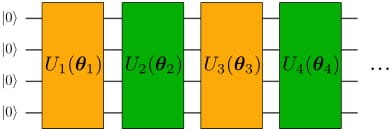

Where the number of layers, denoted with L, has to be considered as a parameter. We call ¨Layer¨ the combination of 1 yellow + 1 green block, so, for example, U1 + U2 is a layer. The odd/even variational blocks are given by:

Even blocks

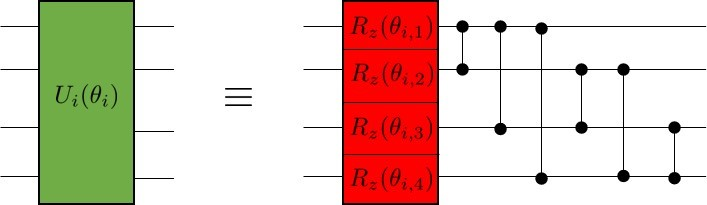


Odd blocks

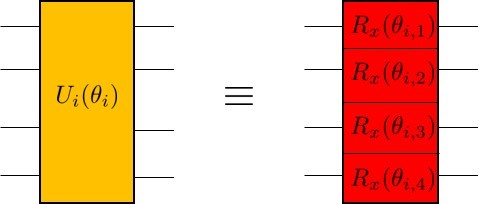


The angles $\theta_{i,j}$ are variational parameters, lying in the interval $(0, 2\pi)$, initialized at random. Double qubit gates are CZ gates.

Report with a plot, as a function of the number of layers, L, the minimum distance

$\epsilon= min_{\theta} \| |\psi(\theta)> - |\phi> \|$

Where $|\phi>$ is a randomly generated vector on 4 qubits and the norm $\| | v> \|$, of a state $| v>$, simply denotes the sum of the squares of the components of $|v >$. The right set of parameters $\theta_{i,j}$ can be found via any method of choice (e.g. grid-search or gradient descent)

Bonus question:
Try using other gates for the parametrized gates and see what happens.





---

The chosen simulator has been the Qiskit *qasm_simulator*. Therefore, the first thing we will do is install Qiskit

In [ ]:
# Intalling Qiskit 
!pip install qiskit

Once we have Qiskit we need to construct the quantum circuit for a given number of layers and qubits. With this circuit we could execute a simulation and obtain a state $|\psi(\theta)>$ generated by this particular distribution of random $\theta$.

In [4]:
from qiskit import *
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

layers = 2
qubits = 4

# Create a Quantum Circuit acting on the q register
qc = QuantumCircuit(qubits)

#Random theta matrix
theta = 2*np.pi*np.random.random_sample((qubits,2*layers))

for l in range(2*layers):
  if l%2!=0:
    #Even Block
    for i in range(qubits):
      qc.rz(theta[i,l], i)
    ##Applying CZ gates at the even block
    for i in range(qubits):
      for j in range(qubits):
        if (j>i):
          qc.cz(i,j)
    qc.barrier()
  else:
    #Odd Block
    for i in range(qubits):
      qc.rx(theta[i,l], i)
    qc.barrier()
result = execute(qc, Aer.get_backend('statevector_simulator')).result()
statevector = result.get_statevector(qc)

print(statevector)
qc.draw()

[-0.19444132-0.10647993j  0.06699681+0.23939047j  0.07902345+0.02937416j
  0.01350963-0.31018188j -0.02304023-0.00301199j -0.08402773-0.29593268j
  0.01946024-0.11213142j  0.02799001+0.05036459j -0.02502207-0.10126499j
  0.07316623+0.57972199j -0.14149939+0.2101709j   0.06566825-0.30433543j
 -0.05077376+0.19844581j  0.10536525-0.0255212j  -0.04270145-0.0633048j
 -0.30423579+0.09255486j]


┌───────────┐  ░  ┌────────────┐                    ░  ┌───────────┐  ░ »
q_0: ┤ RX(2.253) ├──░──┤ RZ(3.6383) ├──■──■──■───────────░──┤ RX(6.001) ├──░─»
     ├───────────┴┐ ░  ├───────────┬┘  │  │  │           ░ ┌┴───────────┴┐ ░ »
q_1: ┤ RX(1.2986) ├─░──┤ RZ(4.459) ├───■──┼──┼──■──■─────░─┤ RX(0.48981) ├─░─»
     ├────────────┤ ░ ┌┴───────────┴─┐    │  │  │  │     ░ └┬────────────┤ ░ »
q_2: ┤ RX(5.2722) ├─░─┤ RZ(0.018605) ├────■──┼──■──┼──■──░──┤ RX(5.6457) ├─░─»
     ├────────────┤ ░ └┬────────────┬┘       │     │  │  ░  ├────────────┤ ░ »
q_3: ┤ RX(5.0595) ├─░──┤ RZ(3.6382) ├────────■─────■──■──░──┤ RX(3.3496) ├─░─»
     └────────────┘ ░  └────────────┘                    ░  └────────────┘ ░ »
«     ┌────────────┐                   ░ 
«q_0: ┤ RZ(4.5135) ├─■──■──■───────────░─
«     ├────────────┤ │  │  │           ░ 
«q_1: ┤ RZ(4.1304) ├─■──┼──┼──■──■─────░─
«     ├────────────┤    │  │  │  │     ░ 
«q_2: ┤ RZ(5.2313) ├────■──┼──■──┼──■──░─
«     ├────────────┤       │     │  │  ░ 
«q_3: ┤ RZ(5.9536) ├───────■─────■──■──░─
«     └────────────┘                   ░

And we save it as a function to be able to call it iteratively in the optimization process of $\theta_{ij}$ parameters

In [3]:
def quantum_evaluation (N,L,theta):
  # Create a Quantum Circuit acting on the q register
  # with N quibits and L layers
  qc = QuantumCircuit(N)

  for l in range(2*L):
    if l%2!=0:
      #Even Block
      for i in range(N):
        qc.rz(theta[i,l], i)
      ##Applying CZ gates
        for j in range(i+1,N):
          qc.cz(i,j)
    else:
      #Odd Block
      for i in range(N):
        qc.rx(theta[i,l], i)
  
  result = execute(qc, Aer.get_backend('statevector_simulator')).result()
  statevector = result.get_statevector(qc)
  
  return statevector

Now that we have defined a way to obtain state $|\psi(\theta)>$ from a matrix $\theta$. We need to be able to calculate the distance between two given states, the target state $|v>$ and the test state $|\psi(\theta)>$. We take the 2-norm of the difference between the two, $\||\psi(\theta)>-|v>\|$


In [5]:
def cost_calculation(target_state,test_state):

  distance = np.linalg.norm(test_state-target_state)

  return distance

#Target state |v>
v = qiskit.quantum_info.random_statevector(2**qubits).data

distance = cost_calculation(v,statevector)

print('distance = ',distance)

distance =  1.5601881585354858


With the distance defined, the goal is to minimize it by varying the theta parameters. We will use a gradient-based algorithms called gradient descent. Here the parameters are updated towards the direction of steepest descent of the loss function $f(\theta)$:

$\theta \leftarrow \theta -\mu\nabla_{\theta }f$

where ${{\rm{\nabla }}}_{{\boldsymbol{\theta }}}f$ is the gradient vector and $\mu$ is the learning rate (a hyperparameter controlling the magnitude of the update). This procedure is iterated and, assuming suitable conditions, converges to a local minimum of the loss function.

The required partial derivatives can be calculated numerically using a finite difference scheme

$\frac{\partial f(\theta)}{\partial\theta_{ij}}\approx\frac{f(\theta+\Delta e_{ij})-f(\theta-\Delta e_{ij})}{2\Delta}$

where $\Delta$ is a (small) hyperparameter and ${{\boldsymbol{e}}}_{ij}$ is the unit vector in the $ij$ direction. Note that in order to estimate the gradient vector ${{\rm{\nabla }}}_{{\boldsymbol{\theta }}}f$, this approach evaluates the loss function twice for each parameter.

As we want to get closer and closer to the minimum of the cost function $f(\theta)$. We have defined a variable learning rate $\mu$, each time the relative variation in the cost value between two iterations exceeds 5%, we will decrease the learning rate by 60%.

Initial distance =  1.3955367675861217
Final distance =  0.4303719508194586
|-------------------------------------|
Gradient at theta =  [[ 0.00036626  0.00122583 -0.00075987 -0.00077555]
 [-0.00131221 -0.00211124  0.00203842 -0.00108139]
 [ 0.0020509   0.00918526  0.00097504 -0.00132873]
 [ 0.00110417  0.00196683 -0.00205454  0.00128678]]


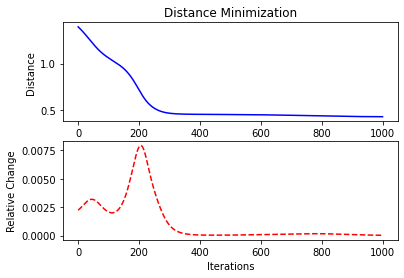

In [5]:

qubits = 4
layers = 2
iter = 1000
pert = 0.01
l_rate = 0.1


#Target state |v>
v = qiskit.quantum_info.random_statevector(2**qubits).data
#Random theta and the initial test state
theta_ini = 2*np.pi*np.random.random_sample((qubits,2*layers))
statevector = quantum_evaluation (qubits,layers,theta_ini)

initial_distance =  cost_calculation(statevector,v)

#Gradient Descent algorithm
optimization = np.zeros((iter,4))
for it in range(iter):
  cost_0 = cost_calculation(statevector,v)
  d_cost = np.zeros((qubits,2*layers)) # Gradient matrix of cost function partial derivates

  for i in range(qubits):
    for j in range(2*layers):

      theta_ini[i][j] += pert
      statevector_plus_ij= quantum_evaluation (qubits,layers,theta_ini) #f(theta + perturbation)
      
      theta_ini[i][j] -= 2*pert
      statevector_minus_ij= quantum_evaluation (qubits,layers,theta_ini) #f(theta - perturbation)

      theta_ini[i][j] += pert

      d_cost[i][j] = (cost_calculation(statevector_plus_ij,v) - cost_calculation(statevector_minus_ij,v)) / (2*pert)
  
  theta_ini -= l_rate*d_cost #theta update 

  statevector = quantum_evaluation (qubits,layers,theta_ini)
  cost_1 = cost_calculation(statevector,v)

  if (cost_0 - cost_1)/cost_0 > 0.05 : l_rate = l_rate/2.5 #learning rate update

  optimization[it][0] = it 
  optimization[it][1] = cost_1
  optimization[it][2] = (cost_0 - cost_1)/cost_0
  optimization[it][3] = l_rate

final_distance =  cost_calculation(statevector,v)


print('Initial distance = ',initial_distance)
print('Final distance = ', final_distance)
print('|-------------------------------------|')
print('Gradient at theta = ', d_cost)

plt.figure()
plt.subplot(211)
plt.title('Distance Minimization')
plt.plot([optimization[i][0] for i in range(iter)], [optimization[i][1] for i in range(iter)], 'b-')
plt.ylabel('Distance')


plt.subplot(212)
plt.plot([optimization[i][0] for i in range(iter)], [optimization[i][2] for i in range(iter)], 'r--')
plt.ylabel('Relative Change')
plt.xlabel('Iterations')
plt.show()

We can see that given the proximity of a minimum of the cost function, the relative change between two iterations is practically zero. In the same way, we can see how the gradient corresponding to the last iteration is almost zero. This was to be expected due to the properties of the extrema values of a function, its derivation becomes zero.

In [5]:

def gradient_descent (qubits,layers,theta_ini,iter = 500, l_rate = 0.1, pert = 0.01):
  statevector = quantum_evaluation (qubits,layers,theta_ini)
  for it in range(iter):
    cost_0 = cost_calculation(statevector,v)
    d_cost = np.zeros((qubits,2*layers)) # Gradient matrix of cost function partial derivates

    for i in range(qubits):
      for j in range(2*layers):

        theta_ini[i][j] += pert
        statevector_plus_ij= quantum_evaluation (qubits,layers,theta_ini) #f(theta + perturbation)
        
        theta_ini[i][j] -= 2*pert
        statevector_minus_ij= quantum_evaluation (qubits,layers,theta_ini) #f(theta - perturbation)

        theta_ini[i][j] += pert

        d_cost[i][j] = (cost_calculation(statevector_plus_ij,v) - cost_calculation(statevector_minus_ij,v)) / (2*pert)

    theta_ini -= l_rate*d_cost #theta update 

    statevector = quantum_evaluation (qubits,layers,theta_ini)
    cost_1 = cost_calculation(statevector,v)

    if (cost_0 - cost_1)/cost_0 > 0.05 : l_rate = l_rate/2.5 #learning rate update
  
  return statevector

In [ ]:
#PLEASE DON'T RUN THIS CELL. It can take a considerable time approximately 3 hours. You can load the results from the file Distance_layer_10.txt
qubits = 4
layers_max = 10

Distance_layer = np.zeros((layers_max,1))
for l in range(layers_max):

  #We define a target state |v>
  v = qiskit.quantum_info.random_statevector(2**qubits).data
  #Random theta
  theta_ini = 2*np.pi*np.random.random_sample((qubits,2*(l+1)))

  test_state = gradient_descent (qubits,l+1,theta_ini,iter = 500, l_rate = 0.1, pert = 0.01)
  Distance_layer[l][0] = cost_calculation(test_state,v)

  #np.savetxt(fname="Distance_layer_"+str(l+1)+".txt", X = Distance_layer)


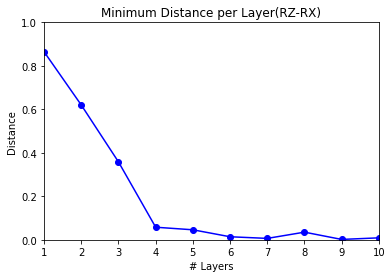

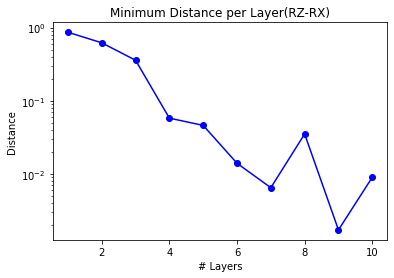

In [6]:
Distance_per_layer = np.loadtxt("/Distance_layer_10.txt")

plt.title('Minimum Distance per Layer(RZ-RX)')
plt.plot([i+1 for i in range(len(Distance_per_layer))], [Distance_per_layer[i] for i in range(len(Distance_per_layer))], marker = 'o',color = 'b')
plt.ylabel('Distance')
plt.xlabel('# Layers')
plt.axis([1, len(Distance_per_layer), 0, 1])
plt.show()

plt.title('Minimum Distance per Layer(RZ-RX)')
plt.plot([i+1 for i in range(len(Distance_per_layer))], [Distance_per_layer[i] for i in range(len(Distance_per_layer))], marker = 'o',color = 'b')
plt.ylabel('Distance')
plt.xlabel('# Layers')
plt.yscale('log')
plt.show()

Since we are not able to know if the minimization of the cost function has been trapped in a local minimum. What we will do is take the minimum average distance for a given number of executions:

In [ ]:
#PLEASE DON'T RUN THIS CELL. You can load the results from the file Distance_layer_stats_10.txt
qubits = 4
layers_max = 10
stats = 5

Distance_layer = np.zeros((layers_max,stats))

for l in range(layers_max):
  for i in range(stats):
    #We define a target state |v>
    v = qiskit.quantum_info.random_statevector(2**qubits).data
    #Random theta
    theta_ini = 2*np.pi*np.random.random_sample((qubits,2*(l+1)))

    test_state = gradient_descent (qubits,l+1,theta_ini,iter = 500, l_rate = 0.1, pert = 0.01)
    Distance_layer[l][i] = cost_calculation(test_state,v)

    #np.savetxt(fname="Distance_layer_stats_"+str(l+1)+".txt", X = Distance_layer)

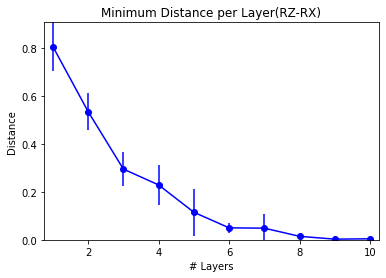

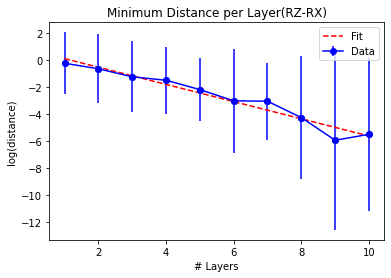

Fit: log(distance) =  -0.635945999749849 *Layer +  0.7614954236067308


In [14]:
#We take advantage of the fact that we already have one execution done
Distance_per_layer_stats_1 = np.loadtxt("/Distance_layer_10.txt")
Distance_per_layer_stats_2 = np.loadtxt("/Distance_layer_stats_10.txt")

Distance_per_layer_stats = np.concatenate((Distance_per_layer_stats_1.reshape(10,1),Distance_per_layer_stats_2),axis=1)


mean_distance_per_layer = [Distance_per_layer_stats[i].mean() for i in range(len(Distance_per_layer_stats))]
std_distance_per_layer = [Distance_per_layer_stats[i].std() for i in range(len(Distance_per_layer_stats))]


plt.title('Minimum Distance per Layer(RZ-RX)')
plt.errorbar([i+1 for i in range(len(mean_distance_per_layer))], [mean_distance_per_layer[i] for i in range(len(mean_distance_per_layer))]
             , yerr=[std_distance_per_layer[i] for i in range(len(std_distance_per_layer))], label='both limits (default)', marker = 'o',color = 'b')
plt.axis([0.75, len(mean_distance_per_layer)+0.25, 0, max(mean_distance_per_layer)+max(std_distance_per_layer)])
plt.ylabel('Distance')
plt.xlabel('# Layers')
plt.show()



x = [i+1 for i in range(len(mean_distance_per_layer))]
y_ln = np.log([mean_distance_per_layer[i] for i in range(len(mean_distance_per_layer))])

A = np.array(([[x[j], 1] for j in range(len(mean_distance_per_layer))]))
B = np.array(y_ln[0:len(mean_distance_per_layer)])

X = np.linalg.lstsq(A,B,rcond=None)[0]
a=X[0]; b=X[1]
y = np.dot(a,x) + b
plt.title('Minimum Distance per Layer(RZ-RX)')
plt.plot(x, y , 'r--',
             label='Fit')
plt.plot(x, y_ln, 'o')
plt.errorbar(x, y_ln
             , yerr=np.log([std_distance_per_layer[i] for i in range(len(std_distance_per_layer))]), label='Data',marker = 'o',color = 'b')
plt.ylabel('log(distance)')
plt.xlabel('# Layers')
plt.legend(loc = 'best')
plt.show()

print('Fit: log(distance) = ',a,'*Layer + ',b)


With these results we see how by increasing the number of layers the distance between a random state and the objective state decreases.
This was to be expected since each layer we introduce we increase the number of free parameters that we can modify. 

-----------------------------

## Bonus question:
Try using other gates for the parametrized gates and see what happens.



In [12]:
layers = 2
qubits = 4

# Create a Quantum Circuit acting on the q register
qc = QuantumCircuit(qubits)

#Random theta matrix
theta = 2*np.pi*np.random.random_sample((qubits,2*layers))

for l in range(2*layers):
  if l%2!=0:
    #Even Block
    for i in range(qubits):
      qc.rz(theta[i,l], i)
    ##Applying CZ gates at the even block
    for i in range(qubits):
      for j in range(qubits):
        if (j>i):
          qc.cz(i,j)
    qc.barrier()
  else:
    #Odd Block
    for i in range(qubits):
      qc.ry(theta[i,l], i)
    qc.barrier()
result = execute(qc, Aer.get_backend('statevector_simulator')).result()
statevector = result.get_statevector(qc)

print(statevector)
qc.draw()

[ 0.21777759-0.17918817j -0.01455542-0.02699684j -0.03128194-0.10408769j
  0.01611102-0.00296058j  0.17730733-0.39020324j  0.03268134+0.03986433j
  0.16457953-0.03372053j  0.00307533-0.027368j   -0.04400573+0.46751299j
 -0.06889868-0.01094662j  0.07327016-0.14234887j -0.01319182-0.00834477j
 -0.61564746-0.06555249j -0.03849869+0.09766253j  0.07955596-0.19911948j
  0.01296892+0.01936374j]


┌────────────┐ ░ ┌────────────┐                   ░ ┌─────────────┐ ░ »
q_0: ┤ RY(6.2177) ├─░─┤ RZ(2.7453) ├─■──■──■───────────░─┤ RY(0.26784) ├─░─»
     ├────────────┤ ░ ├────────────┤ │  │  │           ░ └┬────────────┤ ░ »
q_1: ┤ RY(5.5358) ├─░─┤ RZ(3.2856) ├─■──┼──┼──■──■─────░──┤ RY(6.0921) ├─░─»
     ├────────────┤ ░ ├───────────┬┘    │  │  │  │     ░  ├────────────┤ ░ »
q_2: ┤ RY(5.7124) ├─░─┤ RZ(1.553) ├─────■──┼──■──┼──■──░──┤ RY(1.9553) ├─░─»
     ├────────────┤ ░ ├───────────┴┐       │     │  │  ░  ├────────────┤ ░ »
q_3: ┤ RY(1.0543) ├─░─┤ RZ(2.7318) ├───────■─────■──■──░──┤ RY(2.9378) ├─░─»
     └────────────┘ ░ └────────────┘                   ░  └────────────┘ ░ »
«     ┌────────────┐                   ░ 
«q_0: ┤ RZ(4.9942) ├─■──■──■───────────░─
«     ├────────────┤ │  │  │           ░ 
«q_1: ┤ RZ(1.2485) ├─■──┼──┼──■──■─────░─
«     ├───────────┬┘    │  │  │  │     ░ 
«q_2: ┤ RZ(5.343) ├─────■──┼──■──┼──■──░─
«     ├───────────┴┐       │     │  │  ░ 
«q_3: ┤ RZ(1.2216) ├───────■─────■──■──░─
«     └────────────┘                   ░

In [48]:
def quantum_evaluation_RZ_RY (N,L,theta):
  # Create a Quantum Circuit acting on the q register
  # with N quibits and L layers
  qc = QuantumCircuit(N)

  for l in range(2*L):
    if l%2!=0:
      #Even Block
      for i in range(N):
        qc.rz(theta[i,l], i)
      ##Applying CZ gates
        for j in range(i+1,N):
          qc.cz(i,j)
    else:
      #Odd Block
      for i in range(N):
        qc.ry(theta[i,l], i)

  result = execute(qc, Aer.get_backend('statevector_simulator')).result()
  statevector = result.get_statevector(qc)
  
  return statevector
  
def gradient_descent_RZ_RY (qubits,layers,theta_ini,iter = 500, l_rate = 0.1, pert = 0.01):
  statevector = quantum_evaluation_RZ_RY (qubits,layers,theta_ini)
  for it in range(iter):
    cost_0 = cost_calculation(statevector,v)
    d_cost = np.zeros((qubits,2*layers)) # Gradient matrix of cost function partial derivates

    for i in range(qubits):
      for j in range(2*layers):

        theta_ini[i][j] += pert
        statevector_plus_ij= quantum_evaluation_RZ_RY (qubits,layers,theta_ini) #f(theta + perturbation)
        
        theta_ini[i][j] -= 2*pert
        statevector_minus_ij= quantum_evaluation_RZ_RY (qubits,layers,theta_ini) #f(theta - perturbation)

        theta_ini[i][j] += pert

        d_cost[i][j] = (cost_calculation(statevector_plus_ij,v) - cost_calculation(statevector_minus_ij,v)) / (2*pert)

    theta_ini -= l_rate*d_cost #theta update 

    statevector = quantum_evaluation_RZ_RY (qubits,layers,theta_ini)
    cost_1 = cost_calculation(statevector,v)

    if (cost_0 - cost_1)/cost_0 > 0.05 : l_rate = l_rate/2.5 #learning rate update
  
  return statevector

In [49]:
#PLEASE DON'T RUN THIS CELL. 
#ou can load the results from the file Distance_layer_RZ_RY_10.txt
qubits = 4
layers_max = 10

Distance_layer = np.zeros((layers_max,1))
for l in range(layers_max):

  #We define a target state |v>
  v = qiskit.quantum_info.random_statevector(2**qubits).data
  #Random theta
  theta_ini = 2*np.pi*np.random.random_sample((qubits,2*(l+1)))

  #Highlight that the number of iterations in the optimization process has been reduced due to time problems.
  test_state = gradient_descent_RZ_RY (qubits,l+1,theta_ini,iter = 300, l_rate = 0.1, pert = 0.01)
  Distance_layer[l][0] = cost_calculation(test_state,v)

  #np.savetxt(fname="/content/drive/My Drive/Colab Notebooks/Distance_layer_RZ_RY"+str(l+1)+".txt", X = Distance_layer)

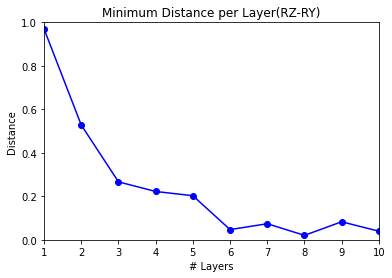

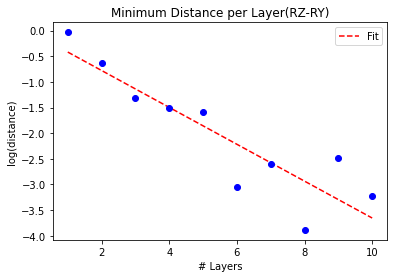

Fit: log(distance) =  -0.35964595898681906 *Layer +  -0.058434157930356986


In [10]:
Distance_per_layer = np.loadtxt("/Distance_layer_RZ_RY10.txt")

plt.title('Minimum Distance per Layer(RZ-RY)')
plt.plot([i+1 for i in range(len(Distance_per_layer))], [Distance_per_layer[i] for i in range(len(Distance_per_layer))], marker = 'o',color = 'b')
plt.ylabel('Distance')
plt.xlabel('# Layers')
plt.axis([1, len(Distance_per_layer), 0, 1])
plt.show()



x = [i+1 for i in range(len(Distance_per_layer))]
y_ln = np.log([Distance_per_layer[i] for i in range(len(Distance_per_layer))])

A = np.array(([[x[j], 1] for j in range(len(Distance_per_layer))]))
B = np.array(y_ln[0:len(Distance_per_layer)])

X = np.linalg.lstsq(A,B,rcond=None)[0]
a=X[0]; b=X[1]
y = np.dot(a,x) + b
plt.title('Minimum Distance per Layer(RZ-RY)')
plt.plot(x, y , 'r--',label='Fit')
plt.plot(x, y_ln, 'bo')
plt.ylabel('log(distance)')
plt.xlabel('# Layers')
plt.legend(loc = 'best')
plt.show()

print('Fit: log(distance) = ',a,'*Layer + ',b)

We see how the adjustment is noticeably worse. But this could be due to the lack of statistics and the decrease of iterations in the minimization.
We leave for a later execution to increase the iterations and generate several measurements per layer. From this way we could compare the two results RX-RZ and RY-RX and obtain an acceptable conclusion.
But, since they are two unit rotations, it is expected that the result will be identical. We would just get a different $\theta$ distribution.